# Analisi diretti competitor

Questo notebook analizza i **diretti competitor** presenti nei bandi di gara ANAC. In particolare, un definiamo *diretti competitor* come segue:
- tutte le aziende che partecipano ad un bando (Partecipanti Multipli);
- tutte le aziende che partecipano ad un bando in raggruppamento (Raggruppamento).

Il notebook è diviso in 4 sezioni.

**1. Analisi Esplorativa diretti competitors.** 
In questa sezione verrà generato il dataset dei *Partecipanti Multipli* e il dataset dei *Raggruppamenti*. I due dataset non sono disgiunti, ma condividono un miliaio di elementi in comune (i.e. bandi e contratti in cui partecipano più aziende in forma di raggruppamento o come singoli);

**2. Generazione Dataset di Itemset.**

Il dataset degli itemset è caratterizzato dalle coppie *<Seq.Id, Itemset>*, dove *Seq.Id* identifica univocamente un bando e *Itemset* rappresenta un itemset di codici fiscali. 

In questa sezione si filtreranno tutti i bandi e contratti che coinvolgono diretti competitor (i.e. tutti i bandi caratterizzati da un raggruppamento e/o più aziende concorrenti) e per ogni bando verrà generato il corrispondente itemset. Ad esempio si consideri il bando con cig *6911006690*. Il bando è caratterizzato da due partecipanti: i) Karon s.r.l (p.iva 02092110036); ii) Agenzia delle Entrate contabilità speciale (p.iva 06363391001). Il dataset degli itemset conterrà la coppia *<Seq.Id, Itemset>*, dove:
- Seq.Id = *6911006690*;
- Itemset = *02092110036 06363391001*.

Il dataset cosi generato verrà dato in input, assieme ad una soglia di supporto mininmo (e.g. 0.3), ad un algoritmo di Frequent Pattern Mining chiamato FPGrow. In particolare, l'algoritmo scopre gruppi di elementi (chiamati appunto itemset) che appaiono frequentemente insieme nel dataset in input. 

**3. Analisi Esplorativa basata su Itemset Frequenti.**

Gli itemset frequenti estratti da FPGrow vengono utilizzati per effettuare analisi esplorative specifiche. In particolare, dato un itemset frequente *I*, si analizzeranno le distribuzioni di alcune feature numeriche e categoriche sul dataset dei bandi a cui hanno partecipato tutte le aziende presenti in *I* ( chiamato di seguito SUBSET). Le distribuzioni così estratte verranno confrontate con quelle ottenute dal dataset dei bandi a cui non hanno partecipato contemporaneamente tutte le aziende  presenti in *I*, ma solo alcune di queste (dataset chiamato di seguito OTHER).

**4. Generazione del Grafo dei Competitor Diretti.**

In questa sezione verrà generato il grafo dei diretti competitor in modo da permettere ulteriori esplorazioni basate su analisi topologiche. Questa sezione non è ancora implementata

## 1. Analisi Esplorativa diretti competitors.

In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')

#from utils import textual_analysis

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import csv
import datetime
from time import time

from IPython.display import Image
from IPython.display import display

import json

In [174]:
def bin_data(df, col, bins):
    df['binned'] = pd.cut(df[col], bins=bins)
    a = df.groupby('binned').size()
    return a.values/len(df)

def plot_couple(data, labels, xlabels, legend, title, orientation = False, filename="img.png"):
    bar_width = 0.8 #ampiezza barra
    opacity_1 = 0.4 #opacità barra
    opacity_2 = 0.8
    
    if(orientation): 
        plt.bar(labels, data[0], bar_width, alpha=opacity_2, color='g', label=legend[0])
        plt.bar(labels, data[1], bar_width, alpha=opacity_1, color='b', label=legend[1])
        plt.xticks(labels, xlabels, rotation='vertical') 
    else:
        plt.barh(labels, data[0], alpha=opacity_2, color='g', label=legend[0])
        plt.barh(labels, data[1], alpha=opacity_1, color='b', label=legend[1])
    #plt.yticks(labels, xlabels, rotation=rotation) 
    
    #plt.legend(loc='upper right')
    plt.legend()
    
    plt.title(title)
    plt.savefig(filename)
    plt.show()
    plt.close()
    
        
def group_by_col(df, col):
    df_sum = df[[col, "importoAggiudicazione"]].groupby([col]).sum().sort_values("importoAggiudicazione",ascending=False).reset_index()
    series_count = df[col].value_counts().reset_index()
    df_count =pd.DataFrame(series_count).rename(columns={col: 'count','index': col})
    df_merged = pd.merge(df_sum, df_count, how='inner', on=[col, col])
    #df_merged = df_merged.sort_values("importoAggiudicazione", ascending= False).head(30)
    return df_merged

def find_raggruppamenti(df):

    index_list = [] 
    for index, row in df.iterrows():

        str_partecipanti = row.jsonPartecipanti
        j = json.loads(str_partecipanti)
        if (len(j["raggruppamento"]) > 0):
        #for raggruppamento in j["raggruppamento"]:
            index_list.append(index)
            
    return df.loc[index_list]


In [3]:
t = time()
dir_ = "data/final_data/row_data/"
file = dir_ + "anac_indicepa_2017_leftjoin.tsv" 
df = pd.read_csv(file, sep="\t")

#pulisco i dati dalla string CDATA ed elimino spazi da i cf degli aggiudicatari
df.oggetto = df.oggetto.apply(lambda x :str(x).lower().replace('cdata', ''))
df.sceltaContraente = df.sceltaContraente.apply(lambda x :str(x).lower().strip().replace('cdata', ''))
df.denominazionePrimoaggiudicatario = df.denominazionePrimoaggiudicatario.apply(lambda x :str(x).lower().strip().replace('cdata', ''))
df.cfPrimoaggiudicatario = df.cfPrimoaggiudicatario.str.replace(' ', '')
df['dataInizio'] = pd.to_datetime(df['dataInizio'], errors='coerce')
df['mese_aggiudicazione'] = df['dataInizio'].map(lambda x: x.month)

df = df.drop_duplicates(subset = ["cig", "oggetto", "cfPrimoaggiudicatario","sceltaContraente", "importoAggiudicazione", "dataInizio", "dataUltimazione"])

total = time() - t
    
print("Loading dataframe done in %0.3f sec" %  total)
df.info(memory_usage='deep')

Loading dataframe done in 31.838 sec
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971995 entries, 0 to 1990224
Data columns (total 27 columns):
Unnamed: 0                           int64
cig                                  object
cfStrutturaProponente                int64
denominazioneStrutturaProponente     object
oggetto                              object
sceltaContraente                     object
importoAggiudicazione                float64
importoSommeLiquidate                float64
dataInizio                           datetime64[ns]
dataUltimazione                      object
jsonPartecipanti                     object
jsonAggiudicatari                    object
totalePartecipanti                   int64
totaleAggiudicatari                  int64
totaleRaggruppamentopartecipanti     int64
totaleRaggruppamentoAggiudicatari    int64
cfPrimoaggiudicatario                object
denominazionePrimoaggiudicatario     object
cod_amm                              object
regione   

In [4]:
df_multiple_competitors = df[df["totalePartecipanti"] > 1 ]
#c'è un bug nel processo di crawling per cui dei data record vengono erroneamente etichettati come raggruppamento, mentre altri vengono erroneamente esclusi
#df_raggruppamento = df[(df["denominazionePrimoaggiudicatario"] == "raggruppamento")]
df_raggruppamento = find_raggruppamenti(df)

print(df_multiple_competitors.shape)
print(df_raggruppamento.shape)

(147640, 27)
(4702, 27)


In [5]:
#df = pd.concat([df_multiple_competitors, df_raggruppamento])
#df = df_raggruppamento

Analisi distribuzione ammontare e numero bandi per importo


/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


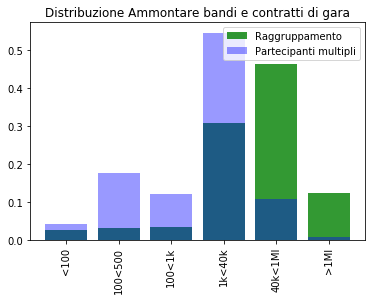

In [6]:
bins = [-0.99, 100, 500, 1000, 40000,1000000, 10000000 ]
labels = [1,2,3,4,5,6]
xlabels = ["<100",  "100<500","100<1k","1k<40k", "40k<1Ml", ">1Ml"]

x1 = bin_data(df_raggruppamento, bins)
x2 = bin_data(df_multiple_competitors, bins)

print("\033[1m" + "Analisi distribuzione ammontare e numero bandi per importo" + "\033[0;0m")

plot_couple([x1,x2], labels, xlabels, ["Raggruppamento", "Partecipanti multipli"], "Distribuzione Ammontare bandi e contratti di gara", orientation=True)

Analisi distribuzione ammontare e numero bandi per scelta contraente


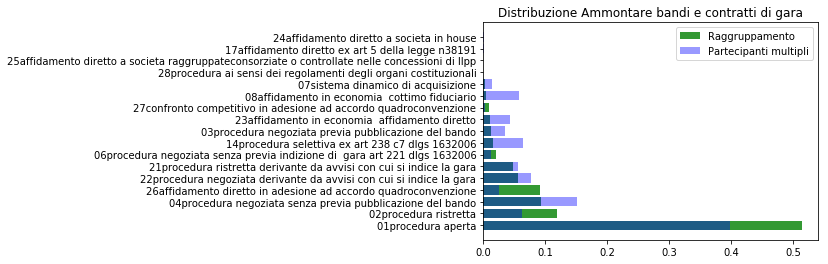

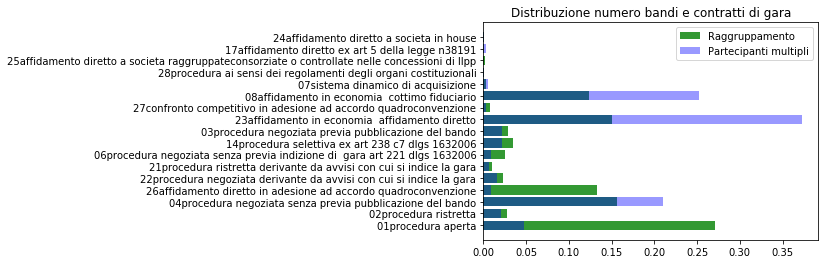

In [7]:
col = "sceltaContraente"

print("\033[1m" + "Analisi distribuzione ammontare e numero bandi per scelta contraente" + "\033[0;0m")

df_group_raggruppamento = group_by_col(df_raggruppamento, col)
df_group_multiple_competitors = group_by_col(df_multiple_competitors, col)

merged_df = pd.merge(df_group_raggruppamento, df_group_multiple_competitors, left_on=col, right_on=col, how='inner')
#plot_couple([merged_df["importoAggiudicazione_x"],merged_df["importoAggiudicazione_y"]], merged_df[col], merged_df[col], ["Raggruppamento", "Partecipanti multipli"], "Distribuzione Ammontare bandi e contratti di gara", False, "ammontare.png")
#plot_couple([merged_df["count_x"],merged_df["count_y"]], merged_df[col], merged_df[col], ["Raggruppamento", "Partecipanti multipli"], "Distribuzione numero bandi e contratti di gara", False, "count.png")
plot_couple([merged_df["importoAggiudicazione_x"] / merged_df["importoAggiudicazione_x"].sum() ,merged_df["importoAggiudicazione_y"]/ merged_df["importoAggiudicazione_y"].sum()], merged_df[col], merged_df[col], ["Raggruppamento", "Partecipanti multipli"], "Distribuzione Ammontare bandi e contratti di gara", False, "ammontare.png")
plot_couple([merged_df["count_x"]/ merged_df["count_x"].sum(), merged_df["count_y"]/merged_df["count_y"].sum()], merged_df[col], merged_df[col], ["Raggruppamento", "Partecipanti multipli"], "Distribuzione numero bandi e contratti di gara", False, "count.png")


Analisi distribuzione ammontare e numero bandi per scelta MESE AGGIUDICAZIONE


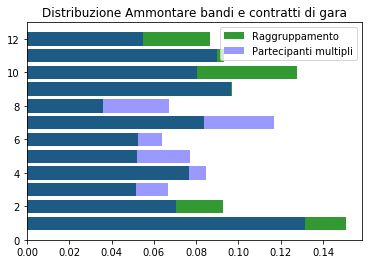

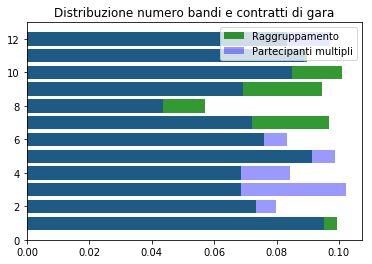

In [8]:
print("\033[1m" + "Analisi distribuzione ammontare e numero bandi per scelta MESE AGGIUDICAZIONE" + "\033[0;0m")

col = "mese_aggiudicazione"

df_group_raggruppamento = group_by_col(df_raggruppamento, col).sort_values([col])
df_group_multiple_competitors = group_by_col(df_multiple_competitors, col).sort_values([col])

merged_df = pd.merge(df_group_raggruppamento, df_group_multiple_competitors, left_on=col, right_on=col, how='inner')
plot_couple([merged_df["importoAggiudicazione_x"] / merged_df["importoAggiudicazione_x"].sum() ,merged_df["importoAggiudicazione_y"]/ merged_df["importoAggiudicazione_y"].sum()], merged_df[col], merged_df[col], ["Raggruppamento", "Partecipanti multipli"], "Distribuzione Ammontare bandi e contratti di gara", False, "ammontare.png")
plot_couple([merged_df["count_x"]/ merged_df["count_x"].sum(), merged_df["count_y"]/merged_df["count_y"].sum()], merged_df[col], merged_df[col], ["Raggruppamento", "Partecipanti multipli"], "Distribuzione numero bandi e contratti di gara", False, "count.png")


Analisi distribuzione ammontare e numero bandi per MESE AGGIUDICAZIONE


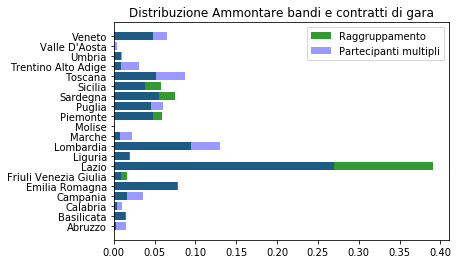

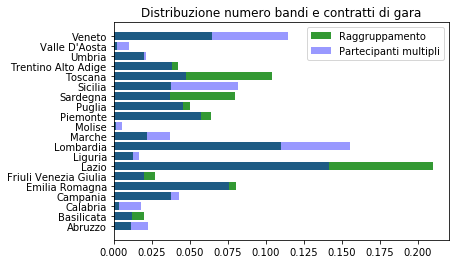

In [9]:
print("\033[1m" + "Analisi distribuzione ammontare e numero bandi per MESE AGGIUDICAZIONE" + "\033[0;0m")

col = "regione"

df_group_raggruppamento = group_by_col(df_raggruppamento, col).sort_values([col])
df_group_multiple_competitors = group_by_col(df_multiple_competitors, col).sort_values([col])

merged_df = pd.merge(df_group_raggruppamento, df_group_multiple_competitors, left_on=col, right_on=col, how='inner')
plot_couple([merged_df["importoAggiudicazione_x"] / merged_df["importoAggiudicazione_x"].sum() ,merged_df["importoAggiudicazione_y"]/ merged_df["importoAggiudicazione_y"].sum()], merged_df[col], merged_df[col], ["Raggruppamento", "Partecipanti multipli"], "Distribuzione AMMONTARE bandi e contratti di gara", False, "ammontare.png")
plot_couple([merged_df["count_x"]/ merged_df["count_x"].sum(), merged_df["count_y"]/merged_df["count_y"].sum()], merged_df[col], merged_df[col], ["Raggruppamento", "Partecipanti multipli"], "Distribuzione NUMERO bandi e contratti di gara", False, "count.png")


Analisi distribuzione ammontare e numero bandi per PROVINCIA


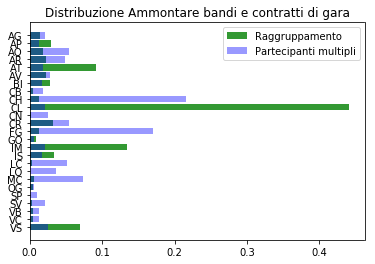

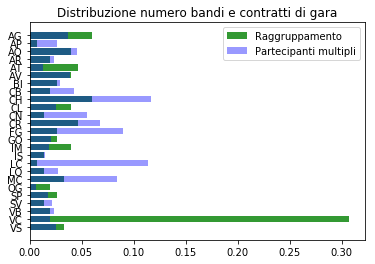

In [10]:
print("\033[1m" + "Analisi distribuzione ammontare e numero bandi per PROVINCIA" + "\033[0;0m")

col = "provincia"

df_group_raggruppamento = group_by_col(df_raggruppamento, col).sort_values([col], ascending= False)
df_group_multiple_competitors = group_by_col(df_multiple_competitors, col).sort_values([col], ascending= False)

#mi permette di selezionare l'unione delle top_n province in termini di ammontare e numero bandi
#le percentuali sono riferite alle top_n, non alle somme totali (quelle cioè ottenute includendo anche le non top_n)

top_n = 20
prov_raggruppamento = df_group_raggruppamento.sort_values(["importoAggiudicazione", "count",]).head(top_n)[col]
prov_multiple_competitors = df_group_multiple_competitors.sort_values(["importoAggiudicazione", "count"]).head(top_n)[col]
union_prov = list(set().union(prov_raggruppamento, prov_multiple_competitors))

#other_sum_raggruppamento = df_group_raggruppamento.loc[~df_group_raggruppamento[col].isin(union_prov)].sum()
#other_sum_multiple_competitors = df_group_multiple_competitors.loc[~df_group_multiple_competitors[col].isin(union_prov)].sum()
#other_raggruppamento_row = ["OTHER", other_sum_raggruppamento[1], other_sum_raggruppamento[2]]
#other_multiple_competitors_row = ["OTHER", other_sum_multiple_competitors[1], other_sum_multiple_competitors[2]]

df_group_raggruppamento = df_group_raggruppamento.loc[df_group_raggruppamento[col].isin(union_prov)]
df_group_multiple_competitors = df_group_multiple_competitors.loc[df_group_multiple_competitors[col].isin(union_prov)]

#df_group_raggruppamento.loc[len(df_group_raggruppamento)] = other_raggruppamento_row
#df_group_multiple_competitors.loc[len(df_group_multiple_competitors)] = other_multiple_competitors_row


merged_df = pd.merge(df_group_raggruppamento, df_group_multiple_competitors, left_on=col, right_on=col, how='inner')
plot_couple([merged_df["importoAggiudicazione_x"] / merged_df["importoAggiudicazione_x"].sum() ,merged_df["importoAggiudicazione_y"]/ merged_df["importoAggiudicazione_y"].sum()], merged_df[col], merged_df[col], ["Raggruppamento", "Partecipanti multipli"], "Distribuzione Ammontare bandi e contratti di gara", False, "ammontare.png")
plot_couple([merged_df["count_x"]/ merged_df["count_x"].sum(), merged_df["count_y"]/merged_df["count_y"].sum()], merged_df[col], merged_df[col], ["Raggruppamento", "Partecipanti multipli"], "Distribuzione numero bandi e contratti di gara", False, "count.png")


In [11]:
del [df_group_raggruppamento, df_group_multiple_competitors, prov_raggruppamento, prov_multiple_competitors, union_prov, merged_df ]

## 2. Generazione Dataset di Itemset.

Vengono generati 2 dataset:
1. Dataset partecipanti (e.g. *|"7212428BDC	| 03538970272	| 72189199.0 |	1835520 |	None |	SEA IMPIANTI SRL	| 04-CAPOGRUPPO"*). Ogni riga contiene le informazioni del partecipante ad una gara;
2. Dataset itemets partecipanti (e.g. "cf1 cf2 ... cfn"). Ogni riga rappresenta l'insieme delle aziende e raggruppamenti che hanno partecipato alla stessa gara;  Questo dataset verrà utilizzato per scoprire le sequenze frequenti dall'algoritmo FPGrow

In [13]:
import hashlib
import rapidjson
import multiprocessing
from functools import partial

schema = {'id_row': int, 
          'cig':str,
          'codiceFiscale': [], 
          'identificativoFiscaleEstero': [], 
          'ragioneSociale': [], 
          'idRaggruppamento': [],
          'ruolo': []
         }

def hash_8_digits(list_cf):
    list_cf.sort()
    string = ("|").join(list_cf)
    return int(hashlib.sha1(string.encode()).hexdigest(), 16) % (10 ** 8)

def getCodiceFiscale_or_identificativoEstero_or_ragioneSociale(membro):
    cf = membro["codiceFiscale"]
    if(cf != None):
        return cf
    elif(membro["identificativoFiscaleEstero"] != None):
        return membro["identificativoFiscaleEstero"]
    else:
        #print("Problema Membro "+ str(membro))
        return membro["ragioneSociale"]

def getCodiceFiscale_or_identificativoEstero(membro):
    cf = membro["codiceFiscale"]
    if(cf != None):
        return cf
    elif(membro["identificativoFiscaleEstero"] != None):
        return membro["identificativoFiscaleEstero"]
    else:
        #print("Problema Membro "+ str(membro))
        return None  

def get_companies(index_list, df):
    """
    df: input dataframe;
    index_list: list of indices (it could be a subset of df indices)
    """
    df_partecipanti = pd.DataFrame(schema)

    for i in index_list:
        data = []

        j = rapidjson.loads(df.loc[i].jsonPartecipanti)
        cig = df.loc[i].cig

        for partecipante in j["partecipante"] :
            dic_ = {}
            dic_["id_row"] = i
            dic_["cig"] = cig
            dic_["codiceFiscale"] = partecipante["codiceFiscale"]
            dic_["identificativoFiscaleEstero"] = partecipante["identificativoFiscaleEstero"]
            dic_["ragioneSociale"] = partecipante["ragioneSociale"]
            data.append(dic_)

        #sevono 2 loop sui membri: uno per estrarre tutti i cf ed ottenere un id univoco raggruppamento e un altro per aggiungere un df
        membri = []
        for raggruppamento in j["raggruppamento"]:

            for membro in raggruppamento["membro"]:
                cf_membro = getCodiceFiscale_or_identificativoEstero_or_ragioneSociale(membro)
                membri.append(cf_membro)
            id_raggruppamento = hash_8_digits(membri)

            for membro in raggruppamento["membro"]:
                dic_ = {}
                dic_["id_row"] = i
                dic_["cig"] = cig
                dic_["codiceFiscale"] = membro["codiceFiscale"]
                dic_["identificativoFiscaleEstero"] = membro["identificativoFiscaleEstero"]
                dic_["ragioneSociale"] = membro["ragioneSociale"]
                dic_["idRaggruppamento"] = id_raggruppamento
                dic_["ruolo"] = membro["ruolo"]    
                data.append(dic_)

        df_partecipanti = df_partecipanti.append(data, ignore_index=True)

    return df_partecipanti   

def parallel_runs(index_list, df):
    pool = multiprocessing.Pool(processes=3)
    prod_x = partial(get_companies, df=df) # prod_x has only one argument x (y is fixed to 10) 
    result_list = pool.map(prod_x, index_list) 
    pool.close()
    pool.join()
    
    return result_list

def generate_df_participants(df, chunck_size = 1000):
    """
    df: input dataframe;
    index_list: list of indices to analyze
    chunck_size
    """
    seq = df.index
    index_list = [seq[i:i+chunck_size] for i  in range(0, len(seq), chunck_size)]
    
    #t = time()
    a = parallel_runs(index_list, df)
    #total = time() - t
    #print("##### Extraction done for %d chunk in %0.3f sec" %(len(seq), total)) 
    return a
    


In [14]:
l_comp = df_multiple_competitors.index.values
l_ragg = df_raggruppamento.index.values
indices = list(set().union(l_comp, l_ragg))
df_union = df.loc[indices]

In [15]:
t = time()
c = generate_df_participants(df_union)
total = time() - t
print("##### Extraction done for %d rows in %0.3f sec" %(len(df_union.index), total))   

df_companies = pd.concat(c)
df_companies.shape

/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can us

##### Extraction done for 150477 rows in 256.027 sec


(853800, 7)

In [16]:
df_companies.head()

,id_row,cig,codiceFiscale,identificativoFiscaleEstero,ragioneSociale,idRaggruppamento,ruolo
0,524288,6911006690,02092110036,None,KARON s.r.l.,NaN,NaN
1,524288,6911006690,06363391001,None,AGENZIA DELLE ENTRATE CONTABILITA' SPECIALE,NaN,NaN
2,524289,691102112F,02092110036,None,KARON s.r.l.,NaN,NaN
3,524289,691102112F,06363391001,None,AGENZIA DELLE ENTRATE CONTABILITA' SPECIALE,NaN,NaN
4,524291,6939434A16,00594870123,None,AUTOLINEE VARESINE S.R.L.,NaN,NaN


In [17]:
#store data as pickle
df_companies.to_pickle("data/competitors_analysis/competitors_df.pickle")

### 2. Generazione Itemsets Dataset

In [19]:
def hash_8_digits(set_cf):
    list_cf = list(set_cf)
    list_cf.sort()
    string = ("|").join(list_cf)
    return int(hashlib.sha1(string.encode()).hexdigest(), 16) % (10 ** 8)

def get_company_itemsets(index_list, df):
    """
    df: input dataframe;
    index_list: list of indices (it could be a subset of df indices)
    """

    partecipanti = []
    
    for i in index_list:
        data = []

        j = rapidjson.loads(df.loc[i].jsonPartecipanti)
        cig = df.loc[i].cig
        
        current_itemset = set()

        for partecipante in j["partecipante"] :
            
            cf_partecipante = getCodiceFiscale_or_identificativoEstero(partecipante)
            if(cf_partecipante != None):
                current_itemset.add(cf_partecipante)
    
        #sevono 2 loop sui membri: uno per estrarre tutti i cf ed ottenere un id univoco raggruppamento e un altro per aggiungere un df
        membri = set()#[]
        for raggruppamento in j["raggruppamento"]:

            for membro in raggruppamento["membro"]:
                cf_membro = getCodiceFiscale_or_identificativoEstero(membro)
                if(cf_membro != None):
                    membri.add(cf_membro)
            id_raggruppamento = hash_8_digits(membri)
            
            current_itemset.add(id_raggruppamento)

            for membro in raggruppamento["membro"]:
                cf_membro = getCodiceFiscale_or_identificativoEstero(membro)
                if(cf_membro != None):
                    current_itemset.add(cf_membro)
        
        partecipanti.append(list(current_itemset))    
    
    return partecipanti
        
def parallel_runs(index_list, df):
    pool = multiprocessing.Pool(processes=3)
    prod_x = partial(get_company_itemsets, df=df) # prod_x has only one argument x (y is fixed to 10) 
    result_list = pool.map(prod_x, index_list) 
    pool.close()
    pool.join()
    return result_list        

def generate_itemset_database(df, chunck_size = 1000):
    """
    df: input dataframe;
    index_list: list of indices to analyze
    chunck_size
    """
    seq = df.index
    index_list = [seq[i:i+chunck_size] for i  in range(0, len(seq), chunck_size)]
    
    #t = time()
    a = parallel_runs(index_list, df)
    #total = time() - t
    #print("##### Extraction done for %d chunk in %0.3f sec" %(len(seq), total)) 
    return a

def get_seqnumber_cf(cf, dict_cf, last_value):
    if(cf in dict_cf):
        return dict_cf[cf]
    else:
        last_value = last_value + 1
        dict_cf[cf] = last_value
        return last_value

In [20]:
l_comp = df_multiple_competitors.index.values
l_ragg = df_raggruppamento.index.values
indices = list(set().union(l_comp, l_ragg))
df_union = df.loc[indices]

In [21]:
#del [df, df_multiple_competitors, df_raggruppamento]

In [22]:
import itertools

t = time()
a = generate_itemset_database(df_union)
total = time() - t
print("##### Extraction done for %d rows in %0.3f sec" %(len(df_union.index), total))   

itemsets = list(itertools.chain.from_iterable(a))

##### Extraction done for 150477 rows in 23.915 sec


In [23]:
value = 0
dict_ = {}
numeric_itemsets = []
for row in itemsets:
    current_itemset = []
    for v in row:
        if(v in dict_):
            current_itemset.append(dict_[v])
        else:
            dict_[v] = value
            current_itemset.append(value)
            value = value + 1
    numeric_itemsets.append(current_itemset)    
    
#save the dataset 

with open("data/competitors_analysis/itemsets.txt", "w") as file:
    counter = 0
    for row in numeric_itemsets:
        if row != None and len(row) !=0:
            file.write(' '.join(str(v) for v in row) + "\n")
       

np.save('data/competitors_analysis/dict_competitors.npy', dict_)             

Per generare le sequenze frequenti utilizzo l'algoritmo FPClose del tool [spmf](http://www.philippe-fournier-viger.com/spmf/index.php?link=algorithms.php)


In [24]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


### 2. Analisi Risultati Pattern Competitors

il file *data/competitors_analysis/frequent_itemsets_0.001.txt* contiene i pattern frequenti estratti dal file *data/competitors_analysis/itemsets.txt* settando il minimo supporto a 0.001. L'algoritmo restituisce 1449 sequenze frequenti **chiuse**.

Si osservi che l'implementazione utilizzata richiede rappresentazioni numeriche degli item. Quindi i codici fiscali vengono convertiti in sequence_id. L'informazione circa il decoding è nella variabile **dict_**.

La seguente sezione effettua un'analisi esplorativa del dataset ANAC in funzione dei pattern frequenti estratti.


**Note**

Prima di procedere se si hanno problemi di memoria non rilasciata dalla computazione sopra, esegui i seguenti comandi:

```bash
$ sudo fuser -v /dev/nvidia*
$ pkill -f ipykernel

```

In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')

#from utils import textual_analysis

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import csv
import datetime
from time import time
import seaborn as sns

from IPython.display import Image
from IPython.display import display

import json

In [2]:
def bin_data(df, col, bins):
    df['binned'] = pd.cut(df[col], bins=bins)
    a = df.groupby('binned').size()
    return a.values/len(df)

def plot_couple(data, labels, xlabels, legend, title, orientation = False, filename="img.png"):
    bar_width = 0.8 #ampiezza barra
    opacity_1 = 0.4 #opacità barra
    opacity_2 = 0.8
    
    if(orientation): 
        plt.bar(labels, data[0], bar_width, alpha=opacity_2, color='g', label=legend[0])
        plt.bar(labels, data[1], bar_width, alpha=opacity_1, color='b', label=legend[1])
        plt.xticks(labels, xlabels, rotation='vertical') 
    else:
        plt.barh(labels, data[0], alpha=opacity_2, color='g', label=legend[0])
        plt.barh(labels, data[1], alpha=opacity_1, color='b', label=legend[1])
    
    plt.legend()
    plt.title(title)

def group_by_col(df, col):
    df_sum = df[[col, "importoAggiudicazione"]].groupby([col]).sum().sort_values("importoAggiudicazione",ascending=False).reset_index()
    series_count = df[col].value_counts().reset_index()
    df_count =pd.DataFrame(series_count).rename(columns={col: 'count','index': col})
    df_merged = pd.merge(df_sum, df_count, how='inner', on=[col, col])
    #df_merged = df_merged.sort_values("importoAggiudicazione", ascending= False).head(30)
    return df_merged
    

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [4]:
dir_ = "data/final_data/row_data/"
file = dir_ + "anac_indicepa_2017_leftjoin.tsv" 

dictionary_competitors = 'data/competitors_analysis/dict_competitors.npy'
dataframe_competitors = 'data/competitors_analysis/competitors_df.pickle'

frequent_itemset_file = "data/competitors_analysis/frequent_itemsets_0.001.txt"

In [5]:
#ricarico il dataframe iniziale
t = time()
df = pd.read_csv(file, sep="\t")

#pulisco i dati dalla string CDATA ed elimino spazi da i cf degli aggiudicatari e campi ridondati
df.oggetto = df.oggetto.apply(lambda x :str(x).lower().replace('cdata', ''))
df.sceltaContraente = df.sceltaContraente.apply(lambda x :str(x).lower().strip().replace('cdata', ''))
df.denominazionePrimoaggiudicatario = df.denominazionePrimoaggiudicatario.apply(lambda x :str(x).lower().strip().replace('cdata', ''))
df.cfPrimoaggiudicatario = df.cfPrimoaggiudicatario.str.replace(' ', '')
df['dataInizio'] = pd.to_datetime(df['dataInizio'], errors='coerce')
df['dataUltimazione'] = pd.to_datetime(df['dataUltimazione'], errors='coerce')
df['mese_aggiudicazione'] = df['dataInizio'].map(lambda x: x.month)
df['duration'] =  df.dataUltimazione - df.dataInizio 
df['duration'] = df["duration"].dt.days

df = df.drop_duplicates(subset = ["cig", "oggetto", "cfPrimoaggiudicatario","sceltaContraente", "importoAggiudicazione", "dataInizio", "dataUltimazione"])

total = time() - t
    
print("Loading dataframe done in %0.3f sec" %  total)
df.info(memory_usage='deep')

Loading dataframe done in 34.199 sec
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971995 entries, 0 to 1990224
Data columns (total 28 columns):
Unnamed: 0                           int64
cig                                  object
cfStrutturaProponente                int64
denominazioneStrutturaProponente     object
oggetto                              object
sceltaContraente                     object
importoAggiudicazione                float64
importoSommeLiquidate                float64
dataInizio                           datetime64[ns]
dataUltimazione                      datetime64[ns]
jsonPartecipanti                     object
jsonAggiudicatari                    object
totalePartecipanti                   int64
totaleAggiudicatari                  int64
totaleRaggruppamentopartecipanti     int64
totaleRaggruppamentoAggiudicatari    int64
cfPrimoaggiudicatario                object
denominazionePrimoaggiudicatario     object
cod_amm                              object
re

In [6]:
dict_ = np.load(dictionary_competitors).tolist()
df_companies = pd.read_pickle(dataframe_competitors)

In [7]:
# genero l'indice inverso dei codici fiscali in modo da ottenere sequenze di codici fiscali frequenti
dict_inv = {}
for k in dict_.keys():
    new_k = dict_[k]
    dict_inv[new_k] = k
    

with open(frequent_itemset_file) as f:
    content = f.readlines()
    list_itemsets_freq = []
    for row in content:
        splitted_row = row.split(" #SUP: ")
        itemset_numeric = [ dict_inv[int(i)] for i in splitted_row[0].split()]
        if(len(itemset_numeric) > 1):
            supp = int(splitted_row[1].strip())
            list_itemsets_freq.append((itemset_numeric, supp))


In [8]:
# stampo alcune statistiche
competitors_in_sequences = set()
supp_list = []
for seq,supp in list_itemsets_freq:
    supp_list.append(supp)
    competitors_in_sequences|= set(seq)
avg = sum(supp_list) / float(len(supp_list))    

In [9]:
sorted_list_itemsets_freq = sorted(list_itemsets_freq, key=lambda x: len(x[0]), reverse=True)

In [10]:
print("Totale aziende analizzate: ", len(dict_))
print("Sequenze frequenti estratte: ",len(list_itemsets_freq))
print("Totale aziende presenti nelle sequenze frequenti: ", len(competitors_in_sequences))
print("Supporto medio dell aziende presenti nelle sequenze frequenti: ", avg)
print("Lunghezza sequenza Massimale", len(sorted_list_itemsets_freq[0][0]))

Totale aziende analizzate:  169614
Sequenze frequenti estratte:  60
Totale aziende presenti nelle sequenze frequenti:  9
Supporto medio dell aziende presenti nelle sequenze frequenti:  473.2
Lunghezza sequenza Massimale 6


In [11]:
t = sorted_list_itemsets_freq[0]
seq = t[0]
supp = t[1]
print("Analisi esplorativa sequenza cf: ", seq)

denominazioni = []
for cf in seq:
    query = "codiceFiscale == @cf"
    denominazione = df_companies.query(query).head(1)["ragioneSociale"].values[0]
    denominazioni.append(denominazione)

print("Denominazioni: ", denominazioni)
print("Supporto: ", supp)

Analisi esplorativa sequenza cf:  ['03645040282', '00315430298', '00605110402', '01252710403', '00668990351', '00325120376']
Denominazioni:  ['A.F. PETROLI', 'ROMANIN PETROLI S.R.L.', 'Centro Petroli Baroni S.r.l.', 'BRONCHI COMBUSTIBILI SRL', 'SCAT PUNTI VENDITA S.P.A.', 'R.O.M.E.A. S.r.l.']
Supporto:  454


In [12]:
#individuo tutti i data record in cui sono presenti contemporaneamente tutte le aziende nella sequenza in analisi t[0]
groups = df_companies.loc[df_companies['codiceFiscale'].isin(t[0])].groupby('id_row').groups

together = []
not_together = []
for key, value in groups.items():
    #print(key, value)
    if len(groups[key]) == len(t[0]):
        together.append(key)
    else:
        not_together.append(key)
        #print(key, value)

In [13]:
print("Bandi e contratti in cui sono presenti tutte le aziende nella seq. in analisi: ", len(together))
print("Bandi e contratti in cui non sono presenti tutte le aziende nella seq. in analisi: ", len(not_together))


Bandi e contratti in cui sono presenti tutte le aziende nella seq. in analisi:  454
Bandi e contratti in cui non sono presenti tutte le aziende nella seq. in analisi:  270


#### Visualizzazione di alcuni bandi in cui la sequenza di aziende in analisi ha partecipato insieme

In [14]:
df.loc[together].head()

,Unnamed: 0,cig,cfStrutturaProponente,denominazioneStrutturaProponente,oggetto,sceltaContraente,importoAggiudicazione,importoSommeLiquidate,dataInizio,dataUltimazione,...,cod_amm,regione,provincia,comune,indirizzo,tipologia_istat,tipologia_amm,name,mese_aggiudicazione,duration
583977,583977,6941804DDE,3836450407,START ROMAGNA SPA,offerta per fornitura gasolio per autotrazione,21procedura ristretta derivante da avvisi con ...,106200.0,54911.03,2017-01-11,2017-01-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,6.0
583978,583978,6949461CA0,3836450407,START ROMAGNA SPA,offerta per fornitura gasolio per autotrazione,21procedura ristretta derivante da avvisi con ...,54906.8,54911.03,2017-01-18,2017-01-20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0
583981,583981,695364488D,3836450407,START ROMAGNA SPA,offerta per fornitura gasolio per autotrazione,21procedura ristretta derivante da avvisi con ...,110670.0,109970.14,2017-01-23,2017-01-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0
583983,583983,6964236D57,3836450407,START ROMAGNA SPA,offerta per fornitura gasolio per autotrazione,21procedura ristretta derivante da avvisi con ...,129917.8,129685.64,2017-02-01,2017-02-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0
583984,583984,6974108FF8,3836450407,START ROMAGNA SPA,offerta per fornitura gasolio per autotrazione,21procedura ristretta derivante da avvisi con ...,111604.5,111269.69,2017-02-09,2017-03-15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,34.0


## 3. Analisi Esplorativa basata su Itemset Frequenti.

Di seguito si analizzerà la distribuzione dei bandi in cui le aziende, presenti nell'itemset frequente *I* in esame, hanno partecipato insieme. In Particolare si analizzeranno le seguenti feature:

- **Feature Numeriche**:
    - Mese Aggiudicazione;
    - Importo Aggiudicato;
    - Importo Liquidato;
    - Durata del progetto in giorni;
- **Feature Categoriche**:
    - Aggiudicatario (i.e. denominazione dell'aggiudicatario o valore *Raggruppamento* per i raggruppamenti di aziende);
    - Denominazione struttura proponente;
    - Regione Struttura proponente;
    - Provincia Struttura proponente;
    - Scelta contraente;
 
La distribuzione del dataset composto dai bandi in cui le aziende in esame hanno partecipato insieme (codificato nella variabile *subset*), verra confrontata con la distribuzione del dataset composto dai bandi in cui non hanno partecipato tutte le aziende della sequenza, ma un suo sottoinsieme S, con 0<|S|< |I| (codificato nella variabile *other*).

Infine verranno realizzate due tipologie di analisi:
- Analisi Univariata, permetterà di vedere come di distribuiscono i dati rispetto alla feature in esame
- Analisi Bivariata, permetterà di scoprire correlazioni tra coppie di feature.

In [15]:
subset = df.loc[together]
other = df.loc[not_together]

In [16]:
cols_categoriche = ["denominazioneStrutturaProponente", "sceltaContraente","denominazionePrimoaggiudicatario", 'regione', 'provincia', 'comune', 'tipologia_istat', 'tipologia_amm']

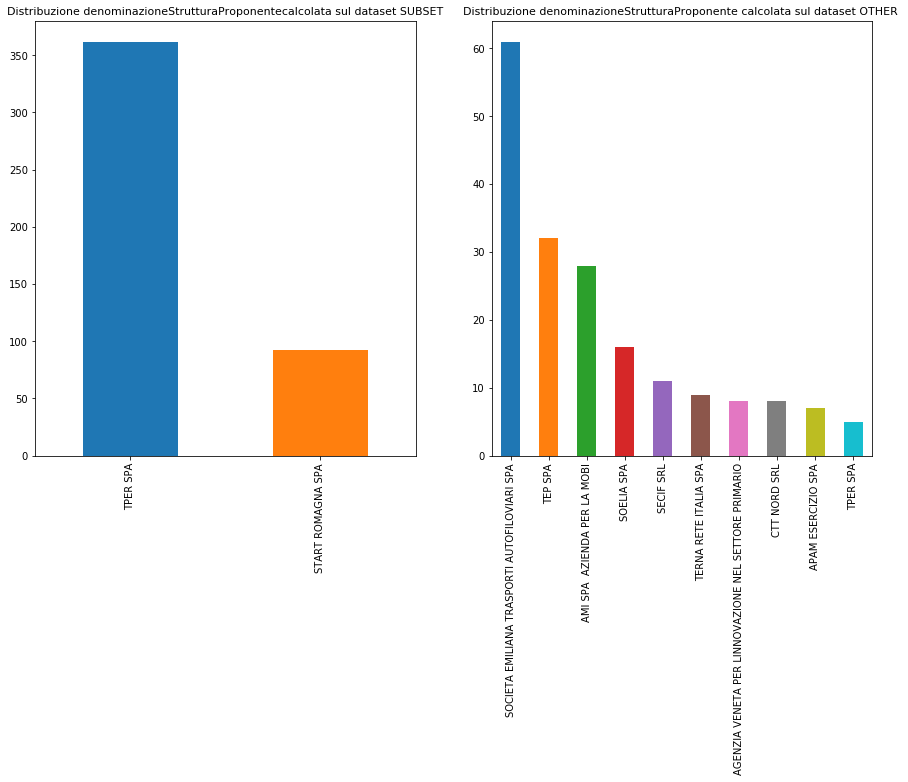

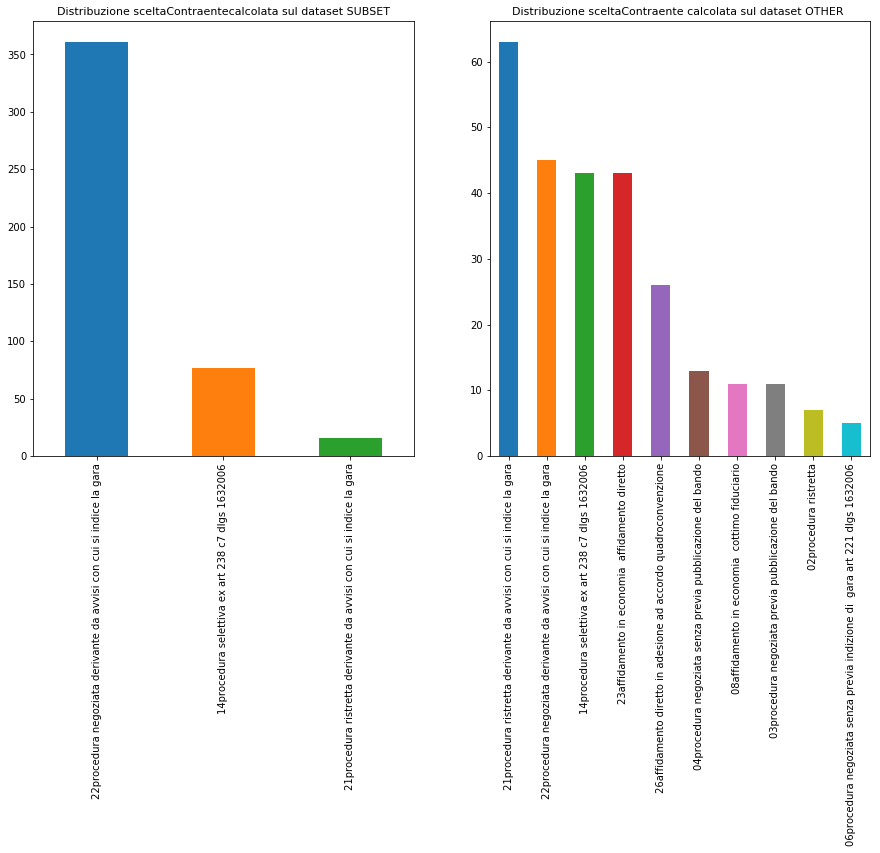

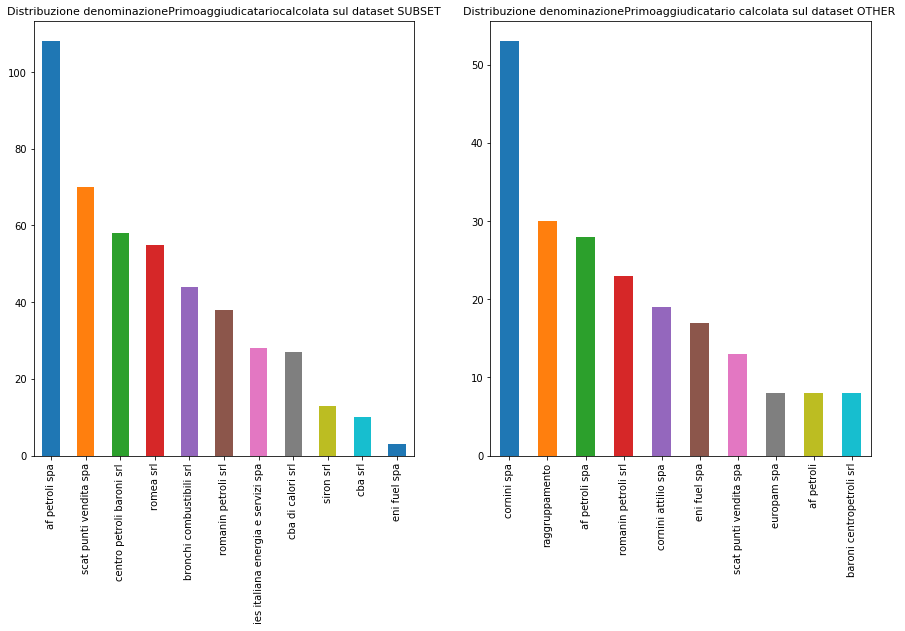

In [17]:
# per migliorare la qualità dei risultati per i campi denominazioneStrutturaProponente e denominazionePrimoaggiudicatario
#converrebbe fare un groupby sui relativi codici fiscali e poi associare ai cf restituiti la denominazione.
#In questo modo si eviterebbe la presenza di aziende con denominazione differente, ma associati alla stessa partita iva/ codice fiscale (e.g. "cba srl" e cba di calori srl").
for c in cols_categoriche:
   
    if len(subset[c].value_counts()) > 0:
        fig = plt.figure(figsize=(15,8))
        fig.add_subplot(121)
        subset[c].value_counts().sort_values(ascending = False).plot.bar()
        plt.title("Distribuzione " + c + "calcolata sul dataset SUBSET", fontsize= 11  )
        
        fig.add_subplot(122)
        other[c].value_counts()[:10].sort_values(ascending = False).plot.bar()
        plt.title("Distribuzione " + c + " calcolata sul dataset OTHER ", fontsize= 11 )
        
        plt.show()
        

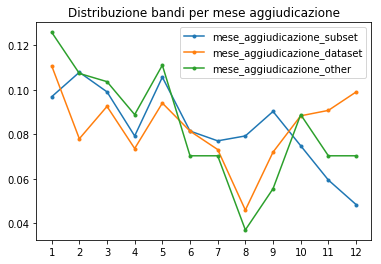

In [18]:
col = "mese_aggiudicazione"

a = subset[col].value_counts().sort_index() / subset[col].value_counts().sum()
b = df[col].value_counts().sort_index() / df[col].value_counts().sum()
df_a = a.to_frame()
df_b = b.to_frame()
df_a.columns = ["mese_aggiudicazione_subset"]
df_b.columns = ["mese_aggiudicazione_dataset"] 


c = other[col].value_counts().sort_index() / other[col].value_counts().sum()
df_c = c.to_frame()
df_c.columns = ["mese_aggiudicazione_other"]

df_mesi_aggiudicazione = pd.concat([df_a, df_b, df_c], axis=1, sort=False)
#df_mesi_aggiudicazione.plot(kind='bar')
df_mesi_aggiudicazione.plot(style='.-')


plt.xticks(df_mesi_aggiudicazione.index)
plt.title("Distribuzione bandi per mese aggiudicazione")
plt.show()

Analisi distribuzione ammontare e numero bandi per importo


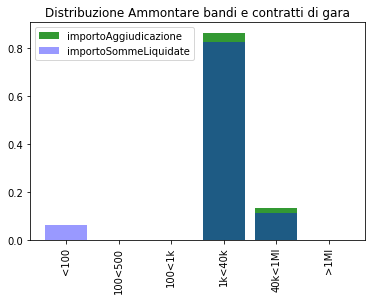

In [19]:



bins = [-0.99, 100, 500, 1000, 40000,1000000, 10000000 ]
labels = [1,2,3,4,5,6]
xlabels = ["<100",  "100<500","100<1k","1k<40k", "40k<1Ml", ">1Ml"]

x1 = bin_data(subset, "importoAggiudicazione", bins)
x2 = bin_data(subset, "importoSommeLiquidate", bins)

print("\033[1m" + "Analisi distribuzione ammontare e numero bandi per importo" + "\033[0;0m")

plot_couple([x1,x2], labels, xlabels, ["importoAggiudicazione", "importoSommeLiquidate"], "Distribuzione Ammontare bandi e contratti di gara", orientation=True)

Analisi distribuzione ammontare e numero bandi per importo


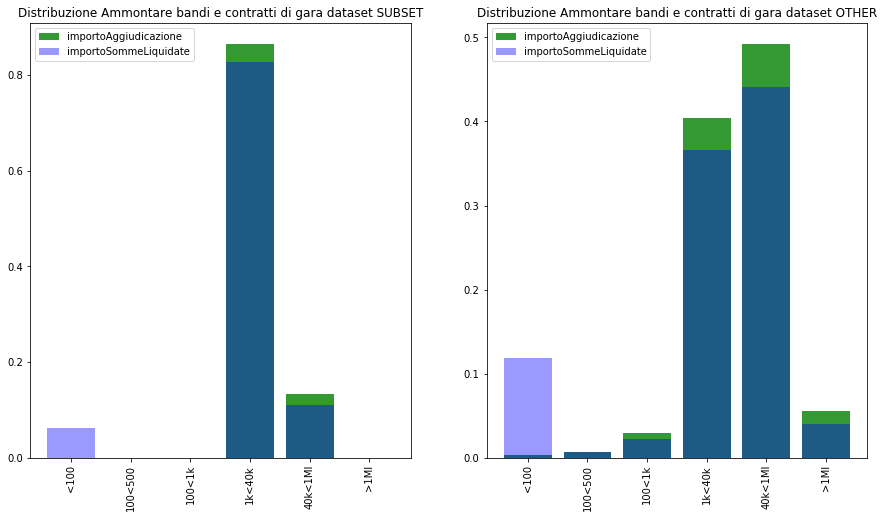

In [20]:
print("\033[1m" + "Analisi distribuzione ammontare e numero bandi per importo" + "\033[0;0m")
bins = [-0.99, 100, 500, 1000, 40000,1000000, 10000000 ]
labels = [1,2,3,4,5,6]
xlabels = ["<100",  "100<500","100<1k","1k<40k", "40k<1Ml", ">1Ml"]
fig = plt.figure(figsize=(15,8))

fig.add_subplot(121)
x1 = bin_data(subset, "importoAggiudicazione", bins)
x2 = bin_data(subset, "importoSommeLiquidate", bins)
plot_couple([x1,x2], labels, xlabels, ["importoAggiudicazione", "importoSommeLiquidate"], "Distribuzione Ammontare bandi e contratti di gara dataset SUBSET", orientation=True)


fig.add_subplot(122)
x1 = bin_data(other, "importoAggiudicazione", bins)
x2 = bin_data(other, "importoSommeLiquidate", bins)        
plot_couple([x1,x2], labels, xlabels, ["importoAggiudicazione", "importoSommeLiquidate"], "Distribuzione Ammontare bandi e contratti di gara dataset OTHER", orientation=True)


In [21]:
##questa cella mostra gli importi liquidati inferiori a 100 euro
subset.query('importoSommeLiquidate < 101').head(3)

,Unnamed: 0,cig,cfStrutturaProponente,denominazioneStrutturaProponente,oggetto,sceltaContraente,importoAggiudicazione,importoSommeLiquidate,dataInizio,dataUltimazione,...,regione,provincia,comune,indirizzo,tipologia_istat,tipologia_amm,name,mese_aggiudicazione,duration,binned
584052,584052,7331781913,3836450407,START ROMAGNA SPA,fornitura gasolio autobus,14procedura selettiva ex art 238 c7 dlgs 1632006,61845.00,0.0,2017-12-21,2018-04-30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,130.0,"(-0.99, 100.0]"
584262,584262,Z3E210EAC7,3836450407,START ROMAGNA SPA,fornitura gasolio autobus,14procedura selettiva ex art 238 c7 dlgs 1632006,37500.75,0.0,2017-11-30,2018-01-30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,61.0,"(-0.99, 100.0]"
584276,584276,Z41216A468,3836450407,START ROMAGNA SPA,fornitura gasolio autobus,14procedura selettiva ex art 238 c7 dlgs 1632006,23955.80,0.0,2017-12-20,2018-02-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,70.0,"(-0.99, 100.0]"


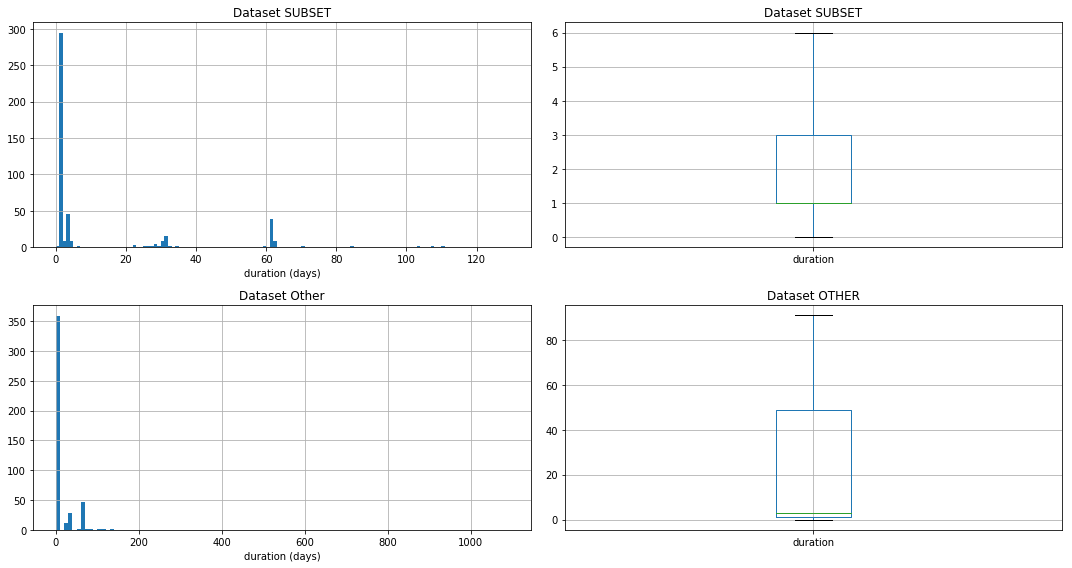

In [23]:
#fare stessa analisi per la durata
col = "duration"
fig = plt.figure(figsize=(15,8))

description_subset = subset[col].describe()
description_other = other[col].describe()

fig.add_subplot(221)
min_ = int(description_subset[3])
max_ = int(description_subset[7])
subset[col].hist(bins=range(min_, max_, 1))
plt.xlabel('duration (days)');
plt.title("Dataset SUBSET")

fig.add_subplot(222)
subset.boxplot([col], showfliers=False)
plt.title("Dataset SUBSET")

fig.add_subplot(223)
min_ = int(description_other[3])
max_ = int(description_other[7])
subset[col].hist(bins=range(min_, max_, 10))
plt.xlabel('duration (days)');
plt.title("Dataset Other")

fig.add_subplot(224)
other.boxplot([col], showfliers=False)
plt.title("Dataset OTHER")

fig.tight_layout()
plt.show()

#### Analisi correlazione tra variabili

In questa sezione analizzeremo eventuali correlazioni tra coppie di feature. Come per la sezione precedente le analisi verranno confrontate con il dataset SUBSET e il dataset OTHER

/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and

Analisi Bivariata tra durata contratto (in giorni) e importo somme liquidate per i dataset SUBSET (a sinistra) e OTHER (a destra)


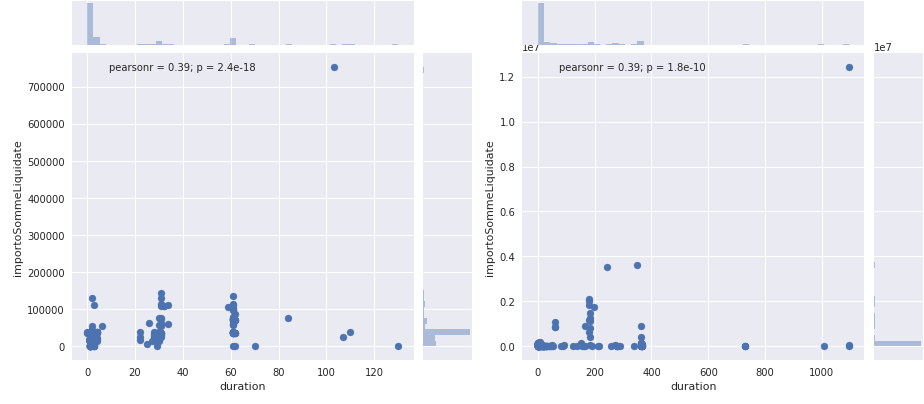

In [24]:
import seaborn as sns; sns.set()

g0 = sns.jointplot(x='duration', y='importoSommeLiquidate', data=subset)
g1 = sns.jointplot(x='duration', y='importoSommeLiquidate', data=other)

fig = plt.figure(figsize=(13,8))
gs = gridspec.GridSpec(1, 2)

mg0 = SeabornFig2Grid(g0, fig, gs[0])
mg1 = SeabornFig2Grid(g1, fig, gs[1])

gs.tight_layout(fig)
gs.update(top=0.7)

print("\033[1m" + "Analisi Bivariata tra durata contratto (in giorni) e importo somme liquidate per i dataset SUBSET (a sinistra) e OTHER (a destra)" + "\033[0;0m")
plt.show()

/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and

Analisi Bivariata tra durata contratto (in giorni) e importo somme aggiudicate per i dataset SUBSET (a sinistra) e OTHER (a destra)


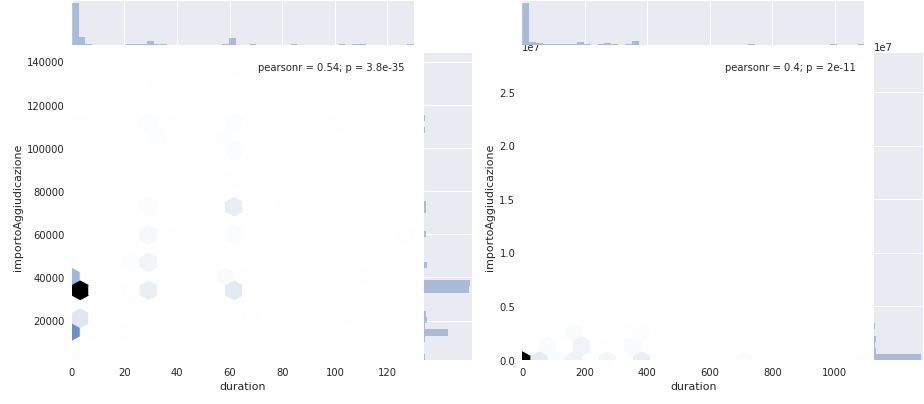

In [25]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from matplotlib import gridspec

g0 = sns.jointplot(x='duration', y='importoAggiudicazione', data=subset, kind='hex', gridsize=20)
g1 = sns.jointplot(x='duration', y='importoAggiudicazione', data=other, kind='hex', gridsize=20)
#g1 = sns.jointplot(x='duration', y='importoAggiudicazione', data=other.query('duration < 120'), kind='hex', gridsize=20)


fig = plt.figure(figsize=(13,8))
gs = gridspec.GridSpec(1, 2)

mg0 = SeabornFig2Grid(g0, fig, gs[0])
mg1 = SeabornFig2Grid(g1, fig, gs[1])

gs.tight_layout(fig)
gs.update(top=0.7)

print("\033[1m" + "Analisi Bivariata tra durata contratto (in giorni) e importo somme aggiudicate per i dataset SUBSET (a sinistra) e OTHER (a destra)" + "\033[0;0m")
plt.show()


######################################################################################################
1. Analisi Bivariata tra denominazioneStrutturaProponente e durata


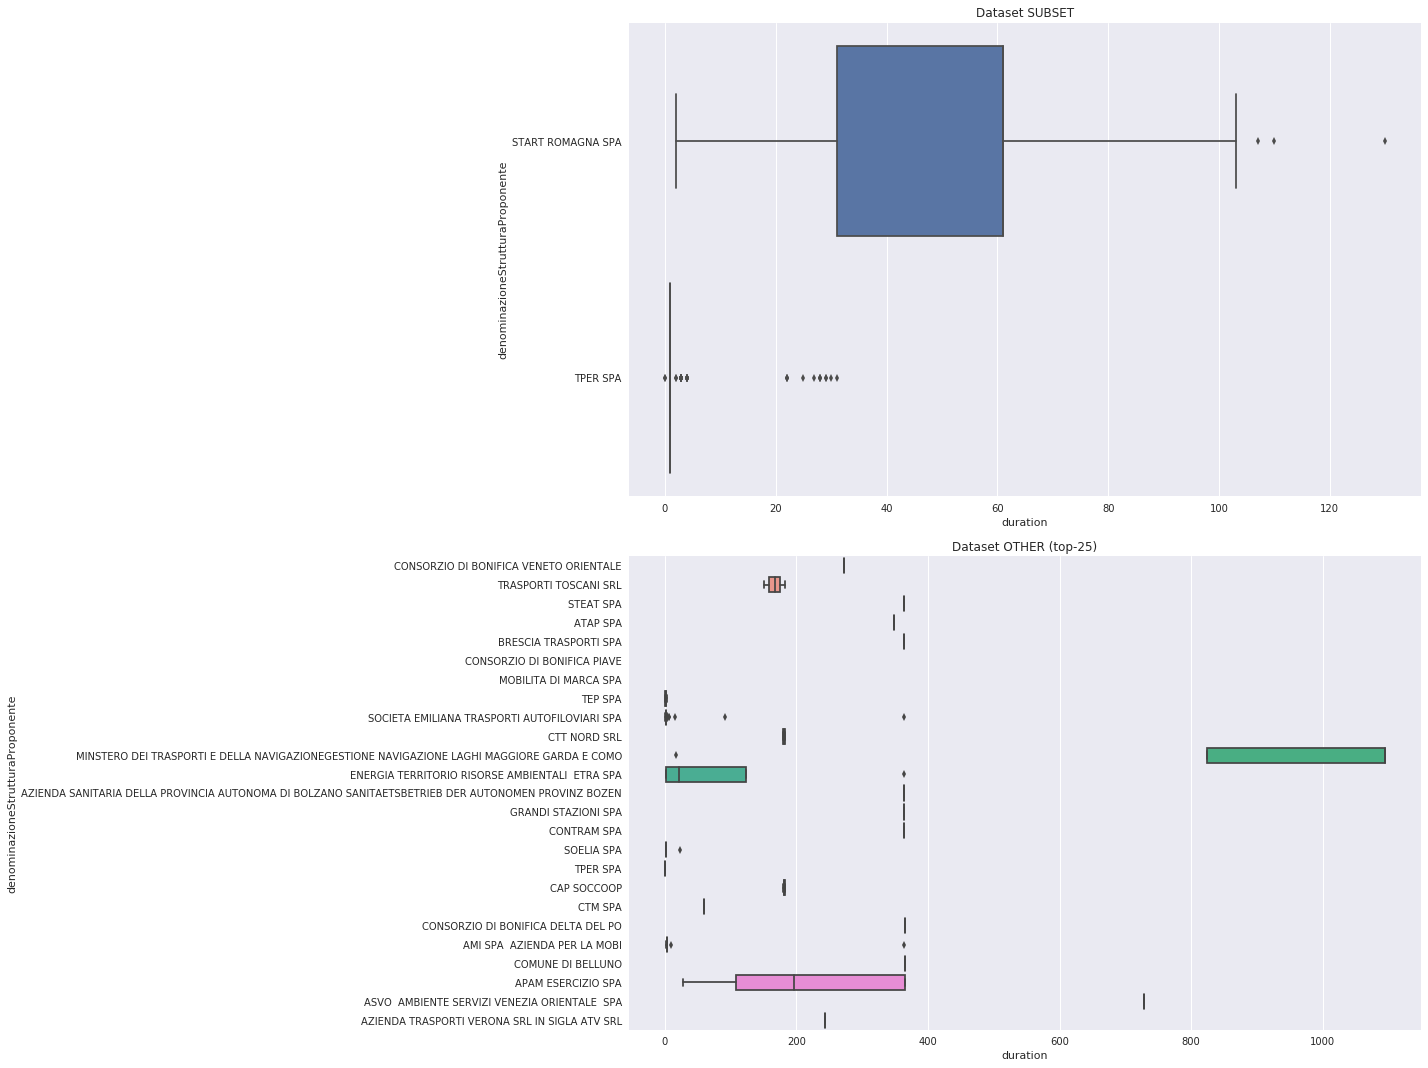

2. Analisi Bivariata tra denominazioneStrutturaProponente e importo Aggiudicazione


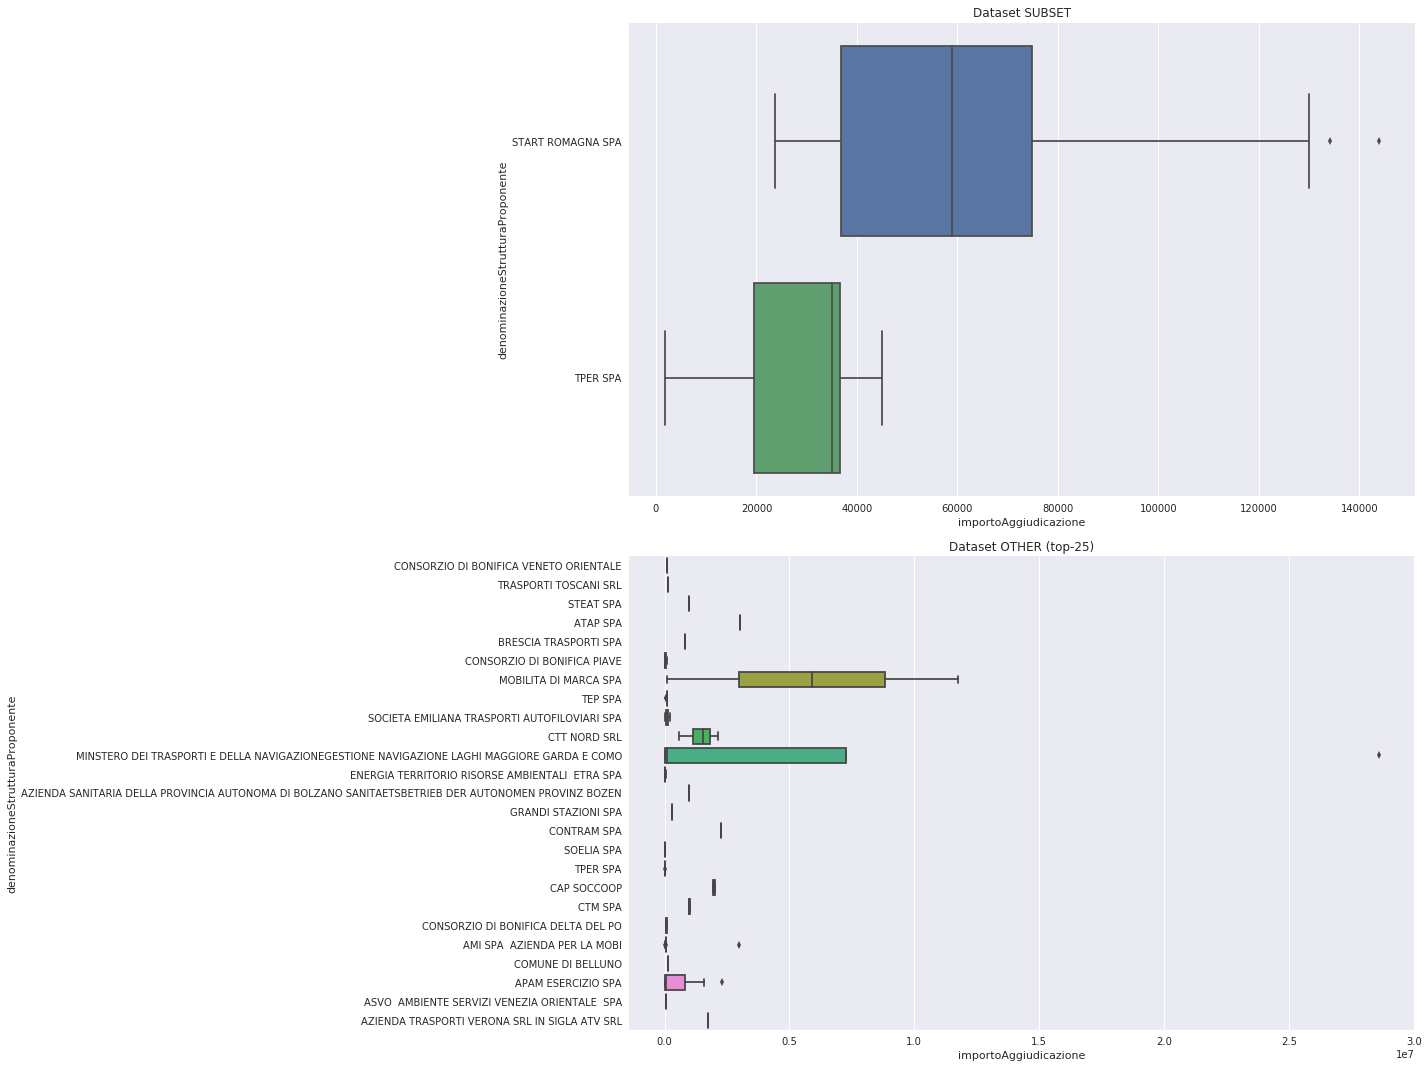

######################################################################################################
######################################################################################################
1. Analisi Bivariata tra sceltaContraente e durata


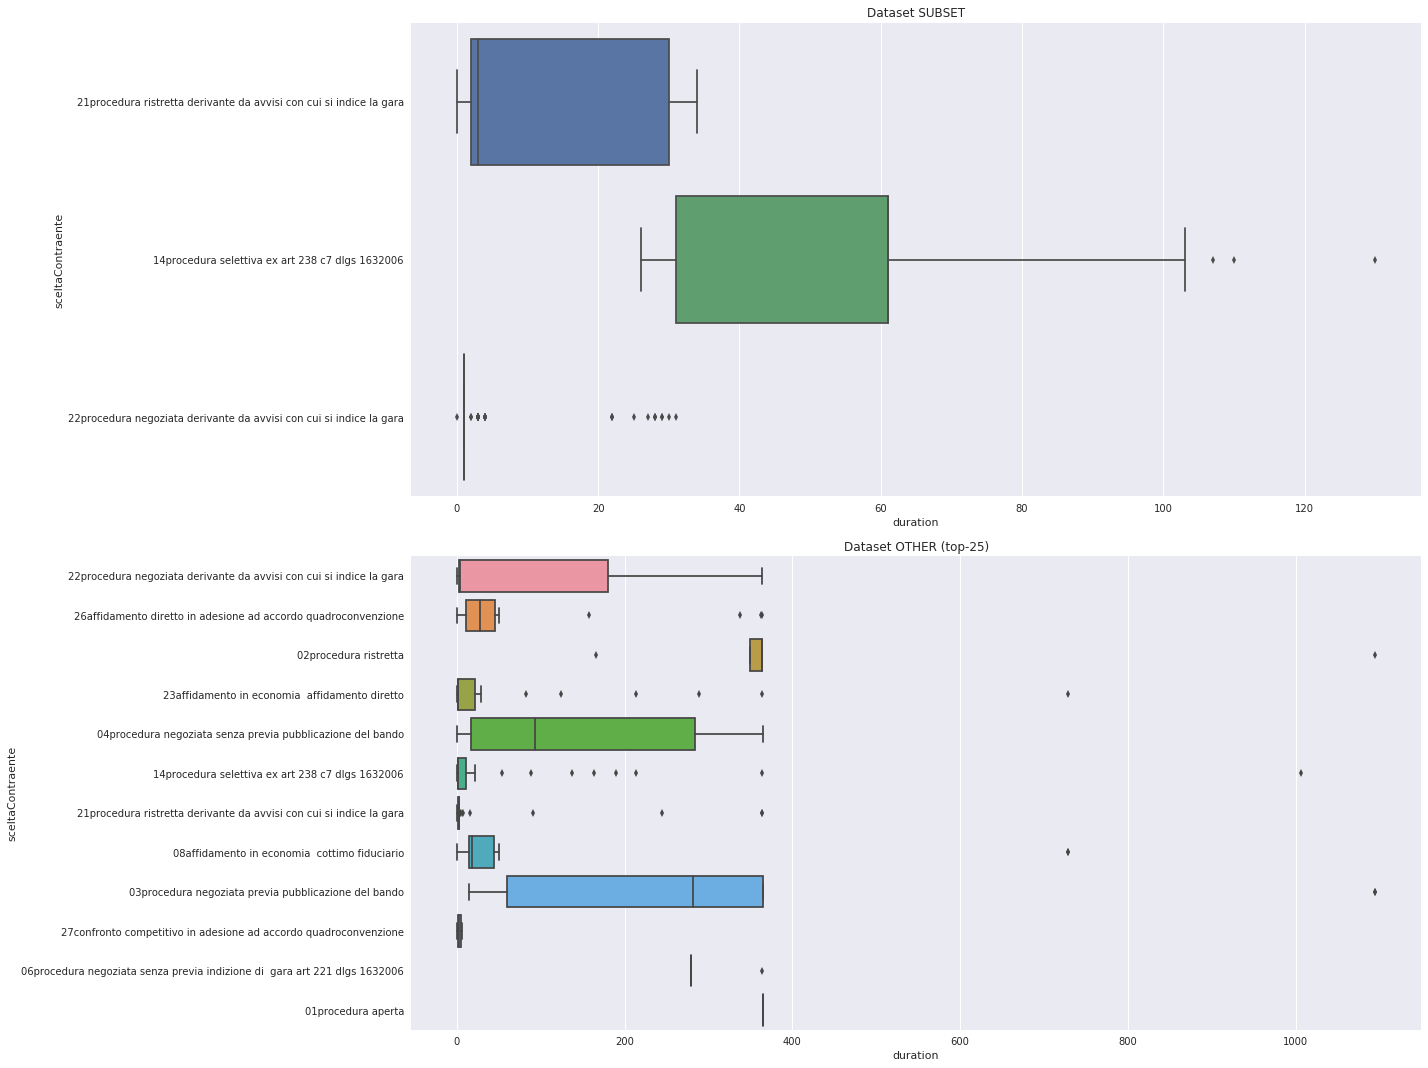

2. Analisi Bivariata tra sceltaContraente e importo Aggiudicazione


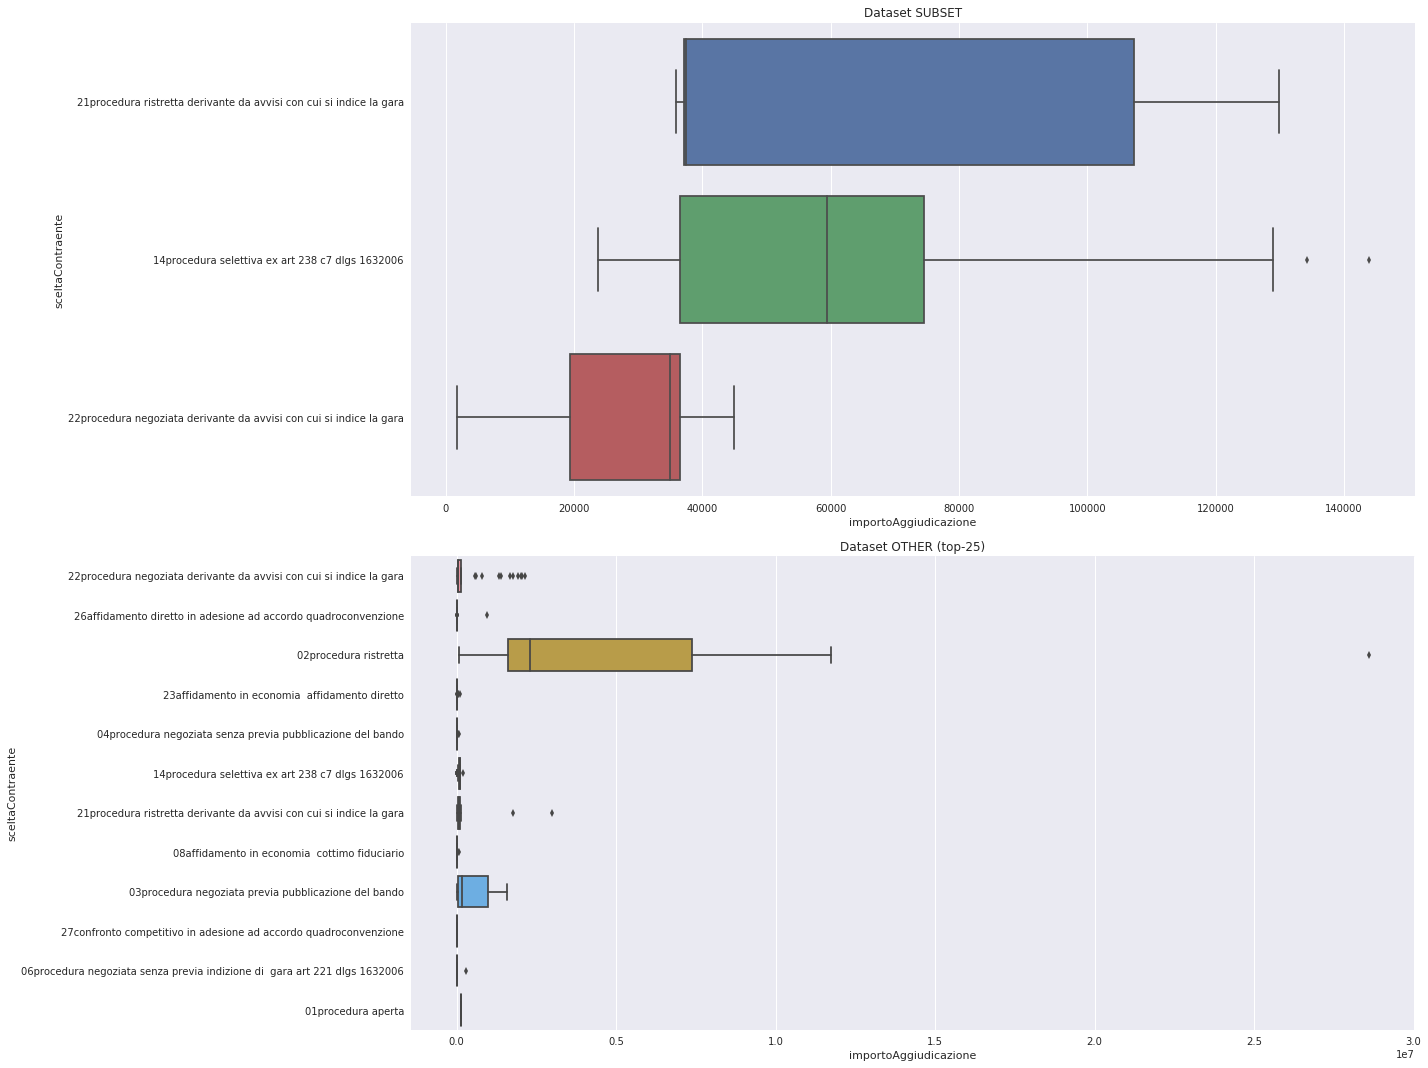

######################################################################################################
######################################################################################################
1. Analisi Bivariata tra denominazionePrimoaggiudicatario e durata


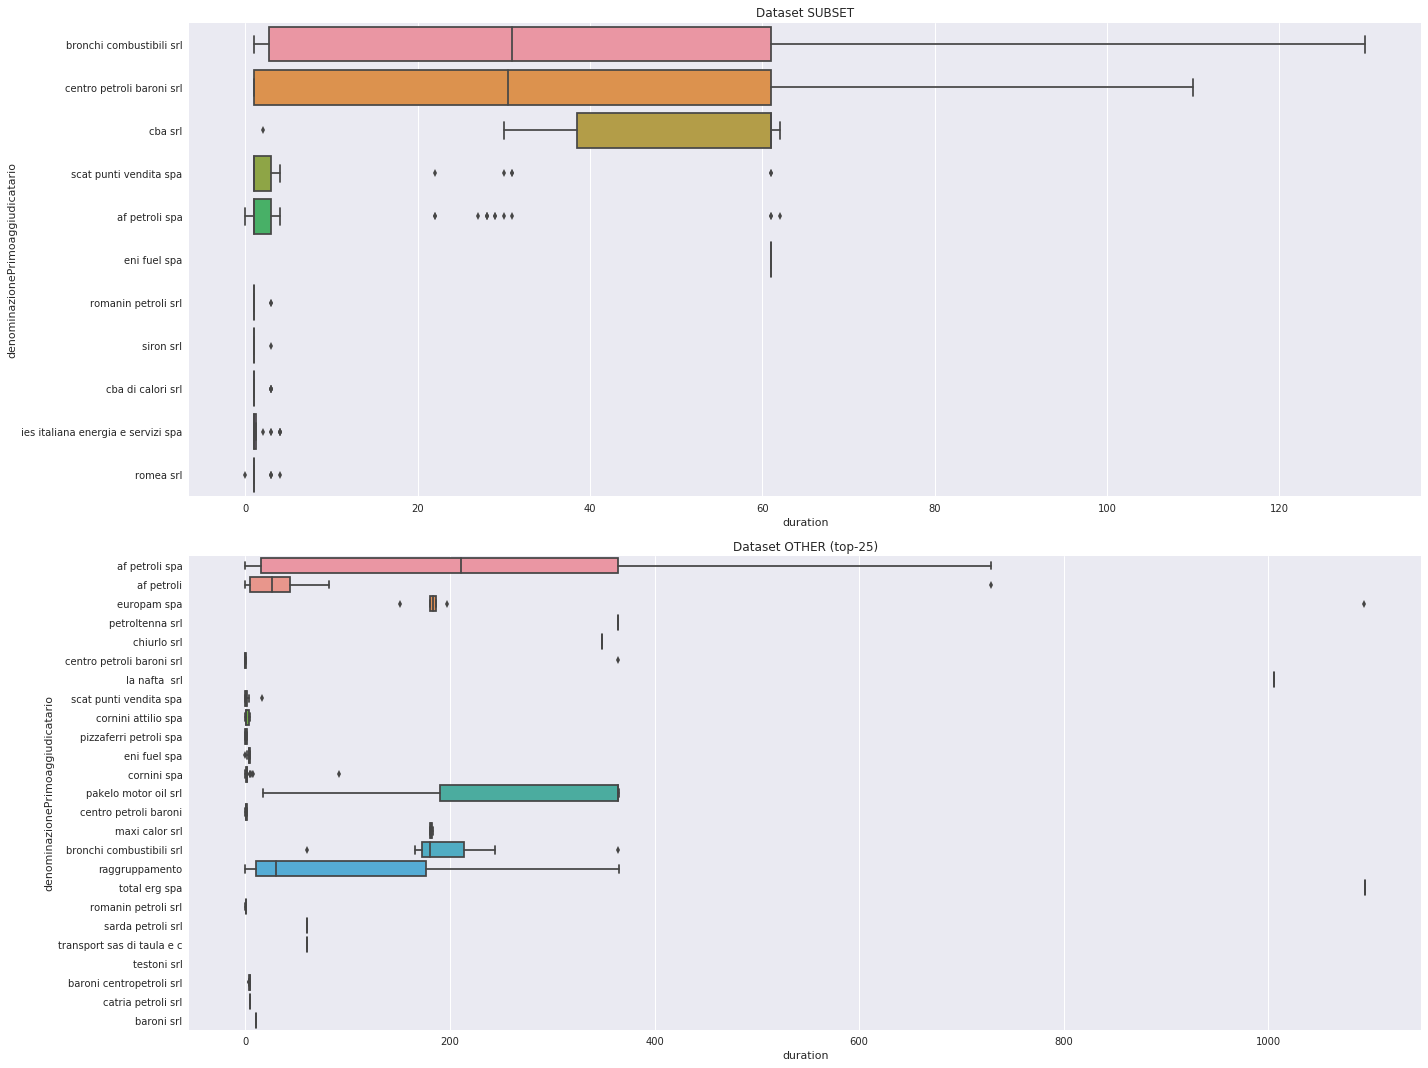

2. Analisi Bivariata tra denominazionePrimoaggiudicatario e importo Aggiudicazione


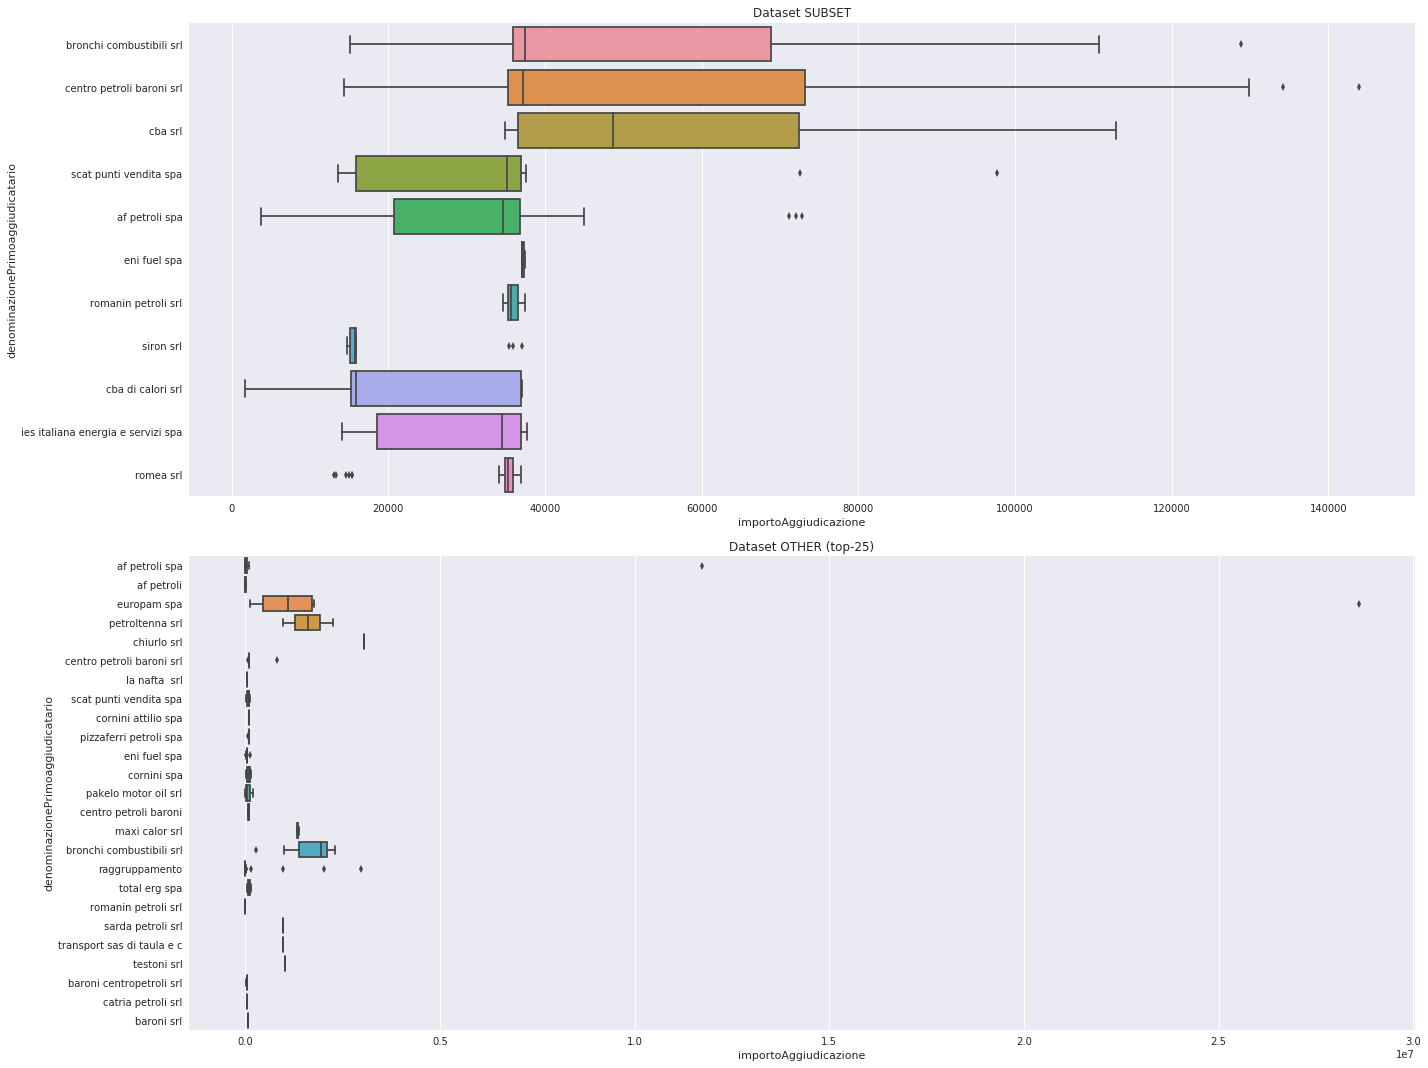

######################################################################################################


In [26]:
top_elements = 25

for col in cols_categoriche:
    if len(subset[col].value_counts()) > 0:
        
        if len(other[col].value_counts()) > top_elements:
            top_values = group_by_col(other, col).sort_values(["importoAggiudicazione"], ascending= False)[:top_elements][col].values
            o = other[other[col].isin(top_values)]
        else:
            o = other
        
        print("######################################################################################################")
        print("\033[1m" + "1. Analisi Bivariata tra "+ col + " e durata" + "\033[0;0m")
        
        fig = plt.figure(figsize=(20,15))
        ax1 = fig.add_subplot(211)
        ax2 = fig.add_subplot(212)
        
        sns.boxplot(x="duration", y=col, data=subset, ax = ax1)
        ax1.set_title("Dataset SUBSET")
        
        sns.boxplot(x="duration", y=col, data=o, ax = ax2)
        ax2.set_title("Dataset OTHER (top-25)")
        
        fig.tight_layout()
        plt.show()
        
        print("\033[1m" + "2. Analisi Bivariata tra "+ col + " e importo Aggiudicazione" + "\033[0;0m")    
        fig = plt.figure(figsize=(20,15))
        ax1 = fig.add_subplot(211)
        ax2 = fig.add_subplot(212)
        
        sns.boxplot(x="importoAggiudicazione", y=col, data=subset, ax = ax1)
        ax1.set_title("Dataset SUBSET")
        
        sns.boxplot(x="importoAggiudicazione", y=col, data=o, ax = ax2)
        ax2.set_title("Dataset OTHER (top-25)")
        
        fig.tight_layout()
        plt.show()
        print("######################################################################################################")
       

######################################################################################################


/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  


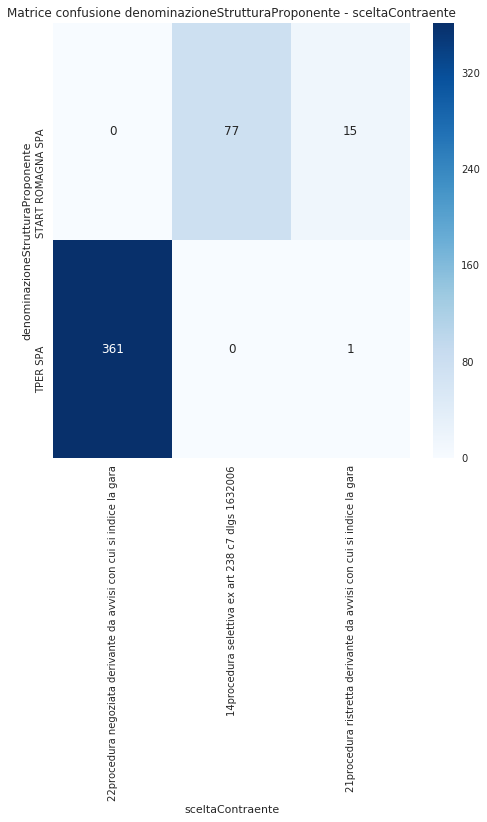

######################################################################################################
######################################################################################################


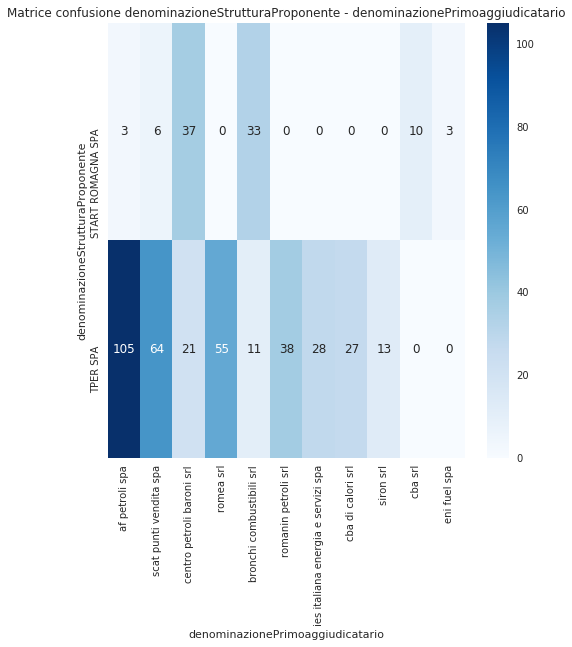

######################################################################################################
######################################################################################################


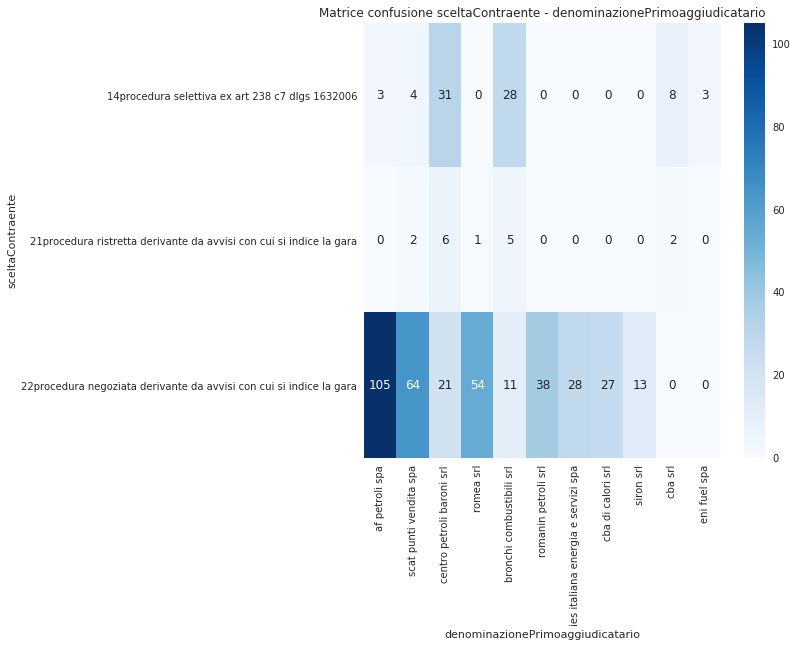

######################################################################################################


In [27]:
for i in range(0, len(cols_categoriche) -1):
    for j in range(i +1, len(cols_categoriche)):
    
        i_distinct_values = len(subset[cols_categoriche[i]].value_counts())
        j_distinct_values = len(subset[cols_categoriche[j]].value_counts())
    
        #print(cols_categoriche[i], cols_categoriche[j])
        #print(i_distinct_values, j_distinct_values)
        if (i_distinct_values>0) & (j_distinct_values > 0):
            print("######################################################################################################")
    
            #Questa tabella mostra la correlazione tra la feature i e j
            confusion_matrix = subset.groupby([cols_categoriche[i], cols_categoriche[j]]).size().sort_values(ascending = False).unstack(fill_value=0)
            confusion_matrix = confusion_matrix.reindex_axis(confusion_matrix.sum().sort_values(ascending = False).index, axis=1)

            plt.figure(figsize = (8,8))
            sns.heatmap(confusion_matrix, annot=True,cmap='Blues', fmt='g')
            plt.title("Matrice confusione "+ cols_categoriche[i] + " - " + cols_categoriche[j])
            plt.show()
            print("######################################################################################################")
       

## 4. Generazione del Grafo dei Competitor Diretti.

Questa sezione genera i file csv da importare in Neo4J per il bulk download del grafo dei competitor.

La funzionalità non è ancora implementata